# E2a: Küchentischversuch zum Laval-Rotor

Name: Vladimir Pascari  
Datum:  07/01/2024

## Forschungsfrage

Wie kann man die Unwucht eines rotierenden Systems untersuchen und auswerten?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

Bild von Aufbau des Haushaltsgegenstands:

![Setup](figures/Setup_handy.jpeg)

Beschreibung des Aufbaus:\
-Ein Accelerometer\
-Raspberry PI\
-Handy\
Vorgangsbeschreibung:\
-Der Accelerometer wird am Handy mit Klebeband befestigt\
-Die Vibration am Handy wird eingeschaltet
-Die Messung wird durchgegührt\

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240107_142045_VladimirPascari_handy" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240107_142045_VladimirPascari_handy.h5" # replace None by the filename of the hdf5-file"
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240107_142045_VladimirPascari_handy/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240107_142045_VladimirPascari_handy/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240107_142045_VladimirPascari_handy/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeac958-5cb2-6a64-a9b7-684f8292a14a": {
    "type": "probe",
    "name": "handy",
    "comment": "",
    "path": "measurement_da

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
f = h5py.File((path_measurement_folder + "/" + h5_file_name), "r")
a = list(f.keys())[0]
b = list(f[a].keys())[0]
c = list(f[a][b].keys())
acc_x = f[a][b][c[0]][()]
acc_y = f[a][b][c[1]][()]
acc_z = f[a][b][c[2]][()]
vec_time = f[a][b][c[3]][()]
print(type(acc_x))

<class 'numpy.ndarray'>


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:

abs_acc = get_vec_accel(acc_x, acc_y, acc_z)
print(vec_time[-1])

1704633665.1531086


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


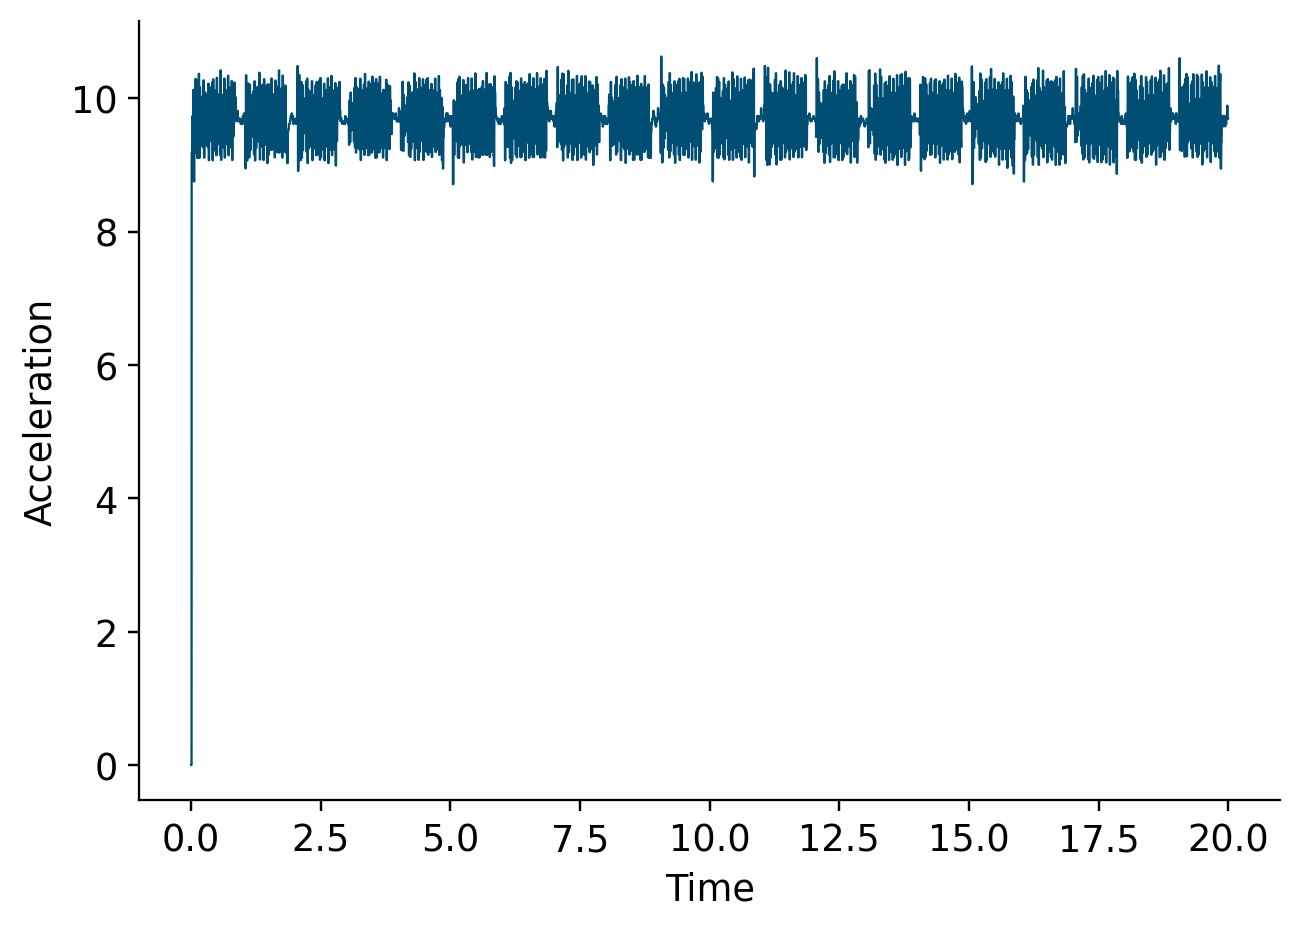

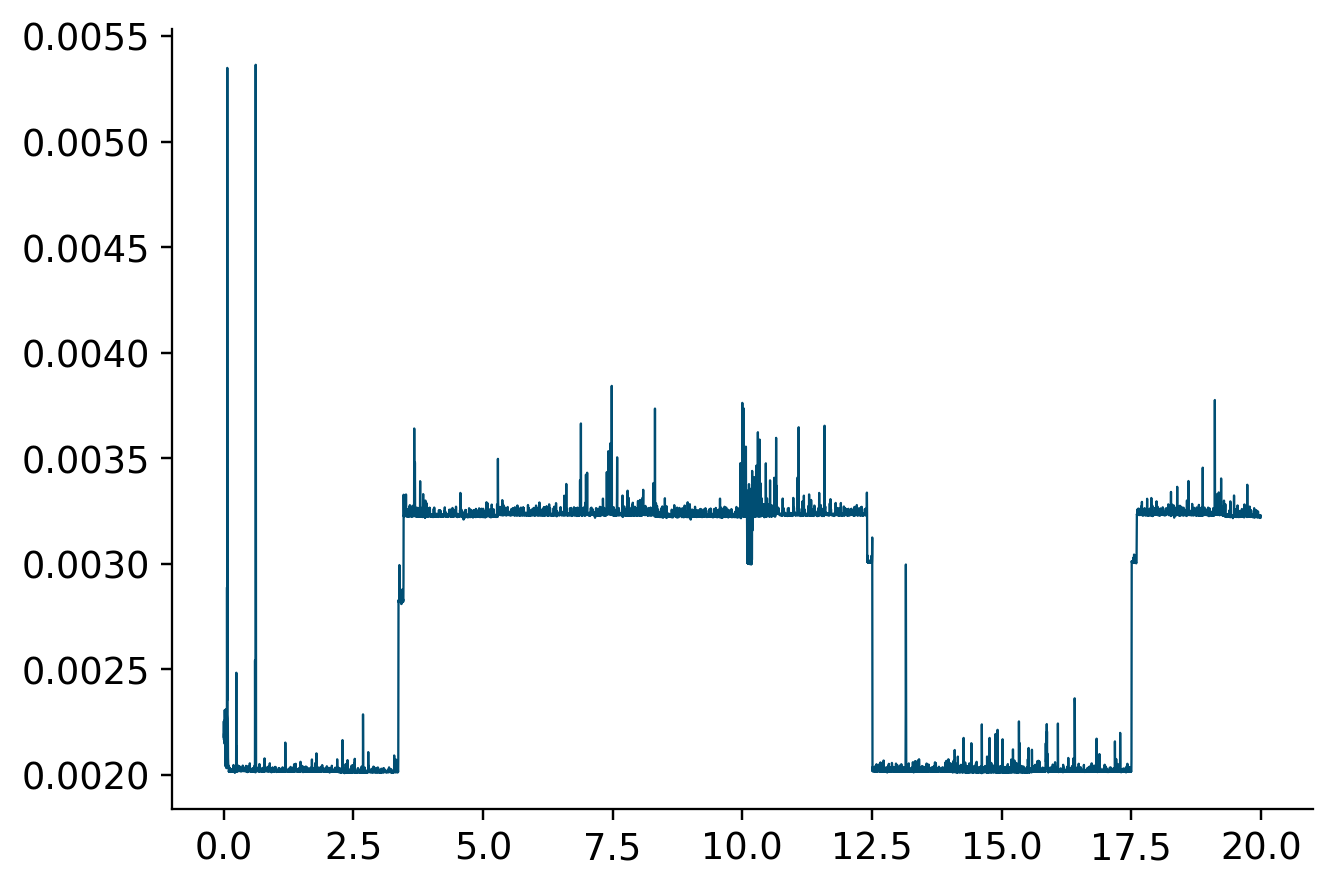

In [6]:
plt.figure(1)
plt.plot(vec_time-vec_time[0], abs_acc)
plt.ylabel("Acceleration")
plt.xlabel("Time")
plt.show

dist = []
plt.figure(2)
for i in range(0, len(vec_time)-1):
    dist.append(vec_time[i+1]-vec_time[i])
plt.plot(vec_time[0:(len(vec_time)-1)]-vec_time[0], dist)

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.


time = np.array([])
for i in vec_time:
    time = np.append(time, i-vec_time[0])
vec_time = time
vec_time_new = np.linspace(vec_time[0], vec_time[-1], num = len(vec_time))

data = interpolation(vec_time, abs_acc)

print(data)

[array([0.00000000e+00, 2.58641300e-03, 5.17282599e-03, ...,
       1.99955589e+01, 1.99981453e+01, 2.00007317e+01]), array([0.        , 0.        , 0.        , ..., 9.69254281, 9.69254281,
       9.69381276])]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


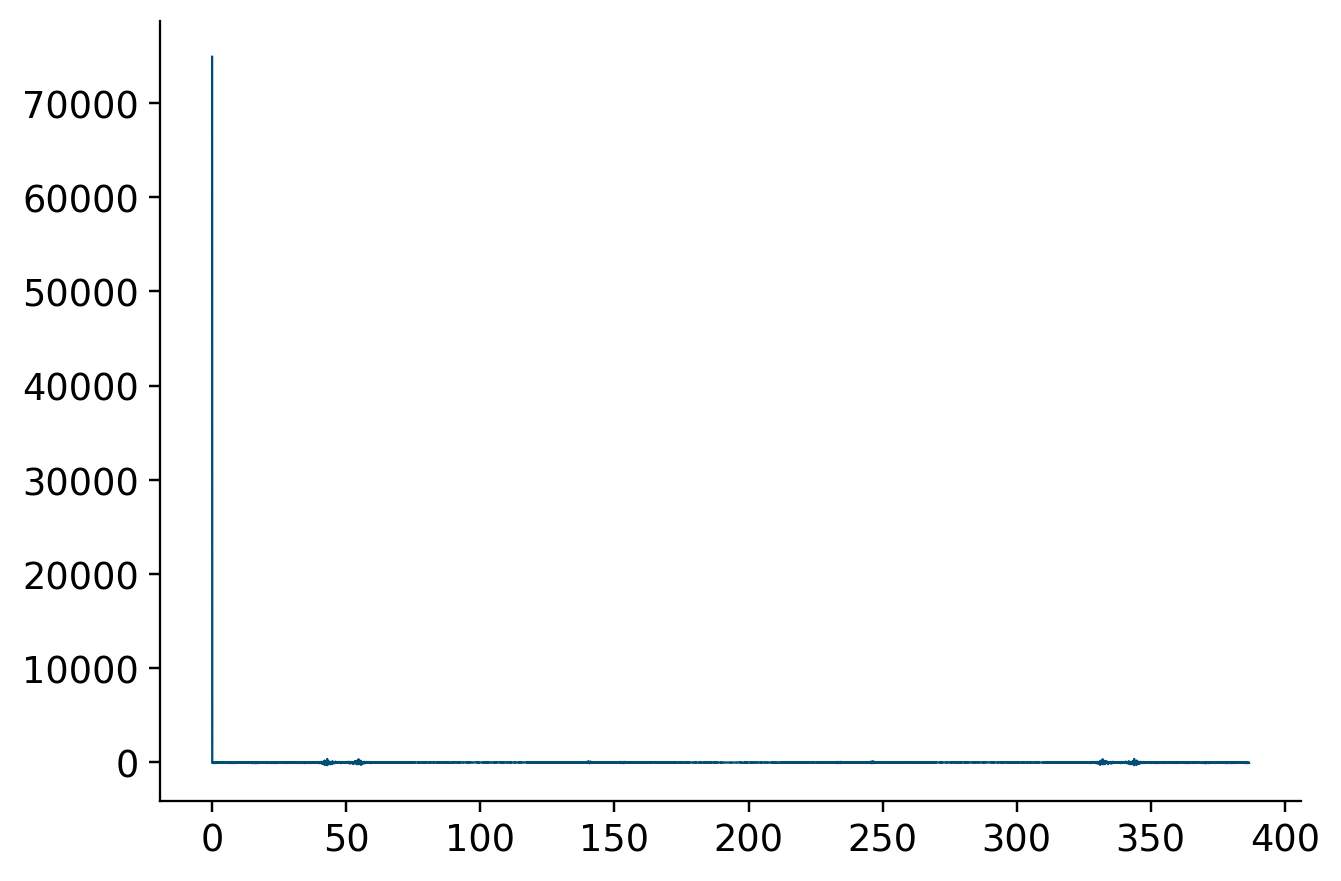

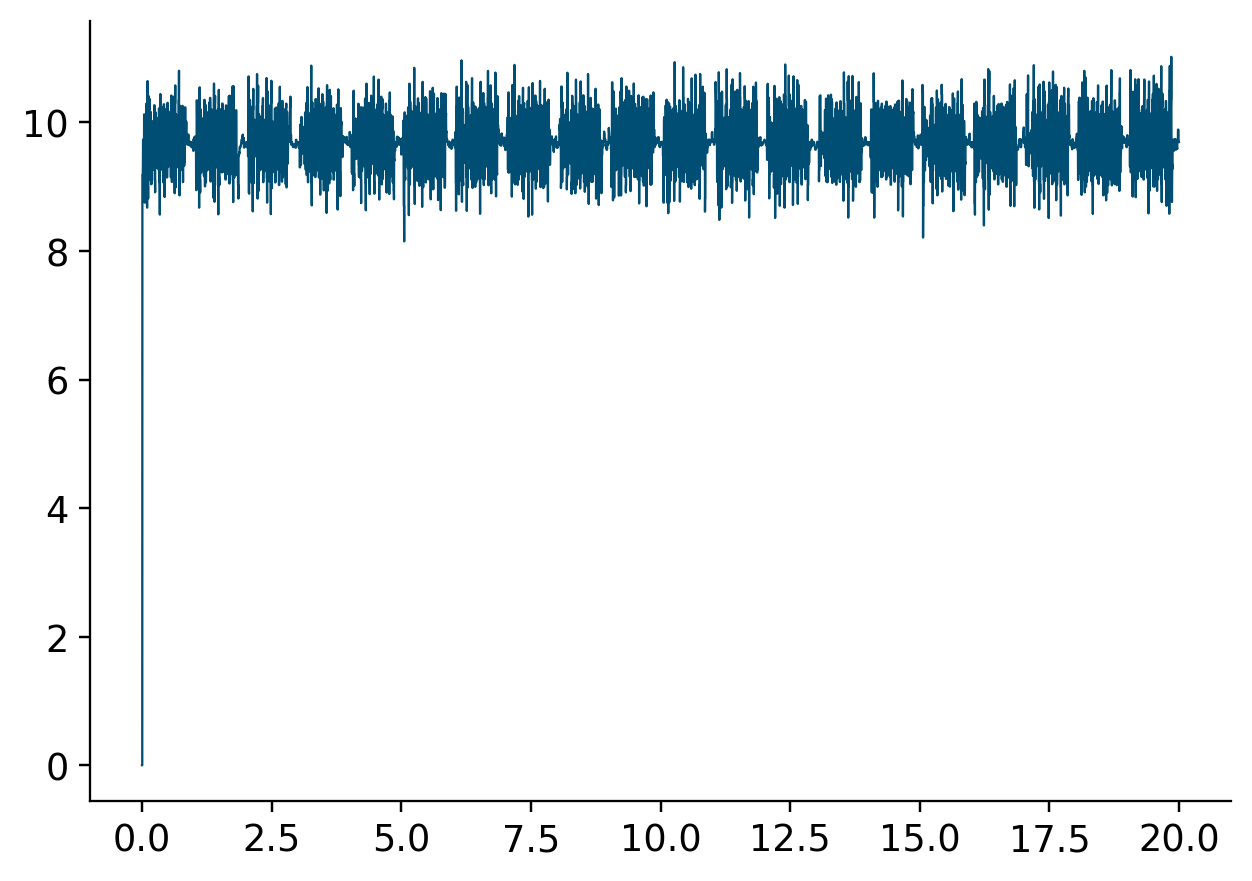

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
from numpy.fft import ifft
data_fft = my_fft(data[1], data[0])
plt.figure(1)
plt.plot(data_fft[1], data_fft[0])

x = ifft(data_fft[0])
plt.figure(2)
plt.plot(data[0][0:7733], x)

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

Bild von Aufbau des Haushaltsgegenstands:

![Setup](figures/Setup_stepmotor.jpeg)

Beschreibung des Aufbaus:\
-Ein Accelerometer\
-Raspberry PI\
-Handy\
Vorgangsbeschreibung:\
-Der Accelerometer wird am Stepmotor mit Klebeband befestigt\
-Der Motor wird eingeschaltet und rotiert solange die Messung läuft\
-Die Messung wird durchgegührt\

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:

path_measurement_folder = "measurement_data/data_20240107_143656_VladimirPascari_stepmotor" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240107_143656_VladimirPascari_stepmotor.h5" # replace None by the filename of the hdf5-file"

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
f = h5py.File((path_measurement_folder + "/" + h5_file_name), "r")
a = list(f.keys())[0]
b = list(f[a].keys())[0]
c = list(f[a][b].keys())
acc_x = f[a][b][c[0]][()]
acc_y = f[a][b][c[1]][()]
acc_z = f[a][b][c[2]][()]
vec_time = f[a][b][c[3]][()]
print(type(acc_x))

<class 'numpy.ndarray'>


#### 2. Betrag der Beschleunigung berechnen


In [11]:
abs_acc = get_vec_accel(acc_x, acc_y, acc_z)
print(vec_time[-1])

1704634637.0092041


#### 3. Darstellung der Messdaten

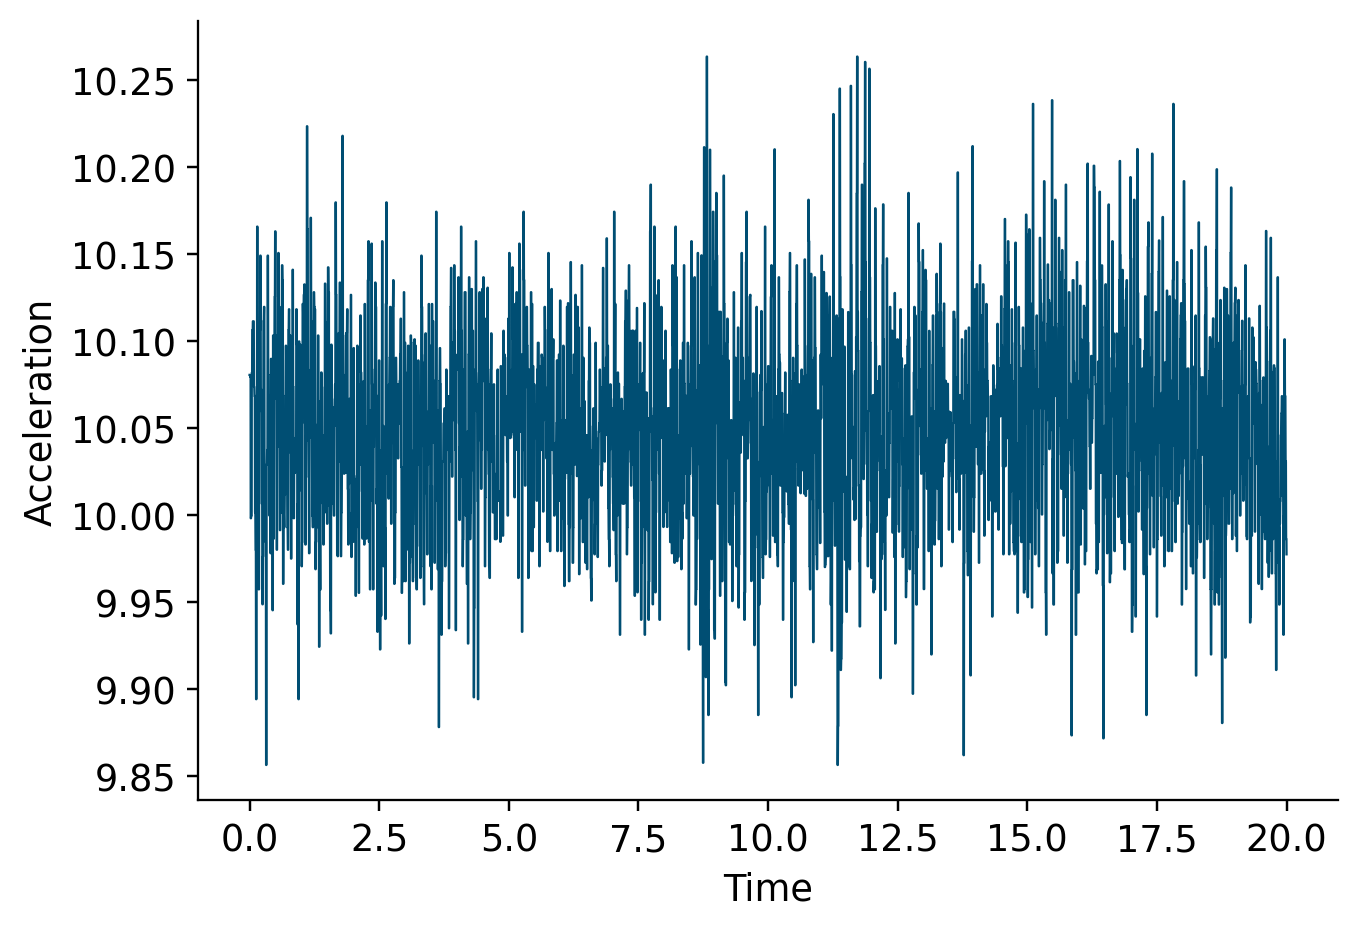

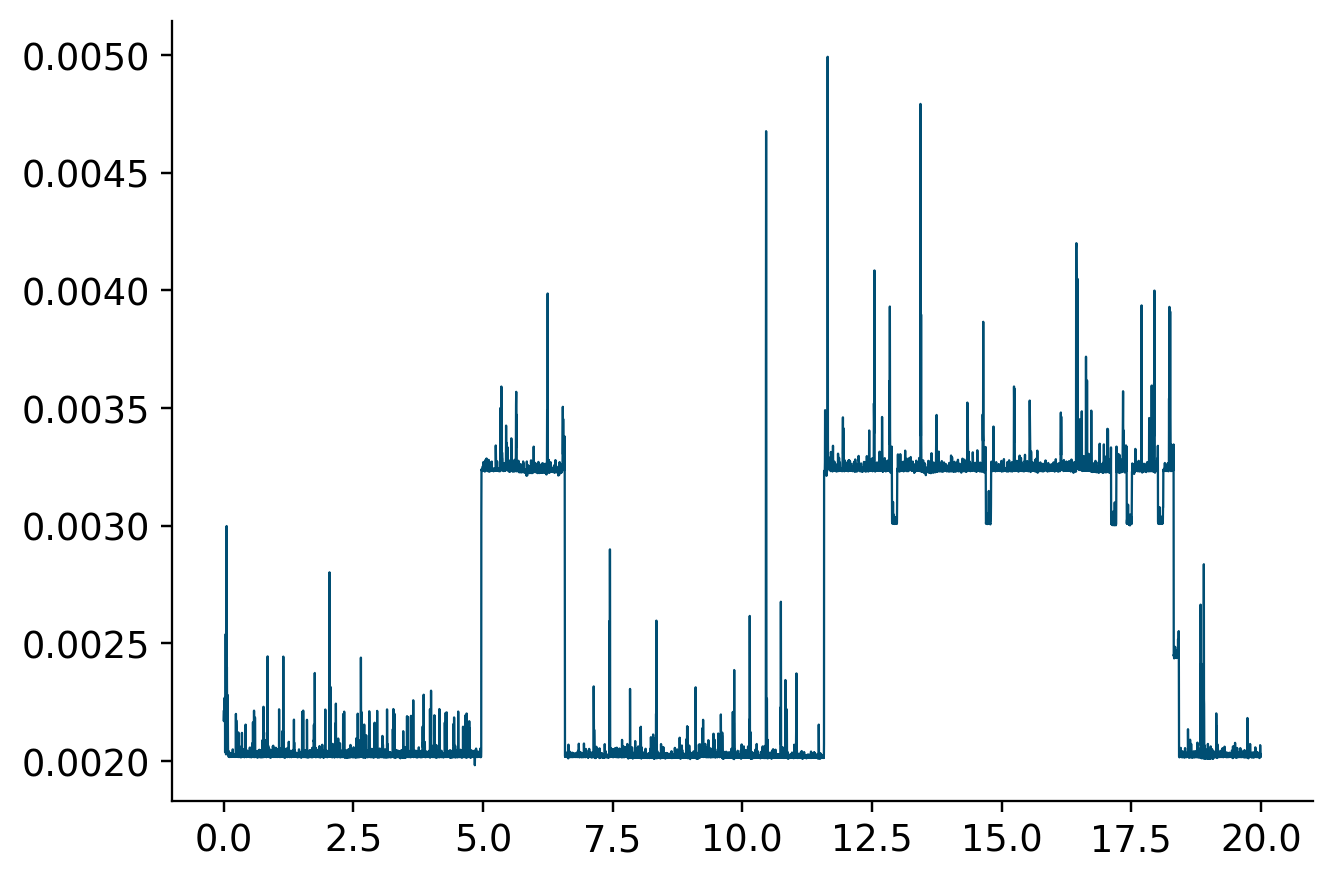

In [12]:
plt.figure(1)
plt.plot(vec_time-vec_time[0], abs_acc)
plt.ylabel("Acceleration")
plt.xlabel("Time")
plt.show

dist = []
plt.figure(2)
for i in range(0, len(vec_time)-1):
    dist.append(vec_time[i+1]-vec_time[i])
plt.plot(vec_time[0:(len(vec_time)-1)]-vec_time[0], dist)

#### 4. Interpolation der Messwerte



In [13]:
time = np.array([])
for i in vec_time:
    time = np.append(time, i-vec_time[0])
vec_time = time
vec_time_new = np.linspace(vec_time[0], vec_time[-1], num = len(vec_time))
data = interpolation(vec_time, abs_acc)

print(data)

[array([0.00000000e+00, 2.40778599e-03, 4.81557197e-03, ...,
       1.99942548e+01, 1.99966626e+01, 1.99990704e+01]), array([10.08062565, 10.08062565, 10.08062565, ...,  9.9862326 ,
        9.9862326 ,  9.97752302])]


#### 5 & 6. FFT durchführen und graphisch darstellen


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


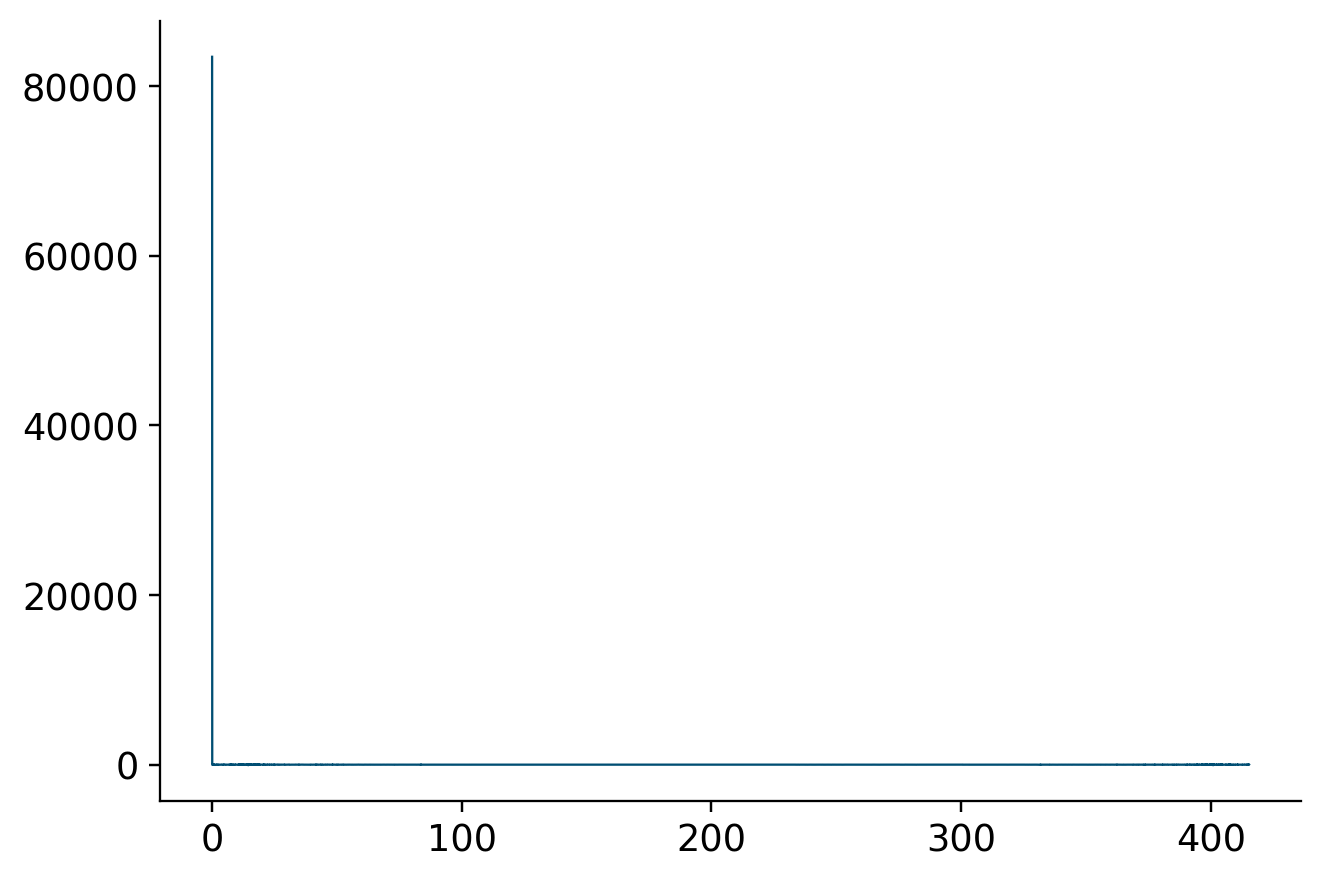

In [14]:
data_fft = my_fft(data[1], data[0])

plt.plot(data_fft[1], data_fft[0])

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Unwucht von 2 rotierenden Systeme konnte untersucht und ausgewertet werden. Beide FFT Graphen weisen einen ähnlichen Verlauf auf, was man mit dem ähnlichem Bereich der Beschleunigungen erklären kann. Die Frequenz der Amplitude sieht komisch aus, da man eher hohe Frequenzen erwarten würde.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Hauptziele des Versuchs wurden erreicht. Die weitere Untersuchung der Frequenz sei notwendig.